<a href="https://colab.research.google.com/github/leticyadanielly/projeto1/blob/main/RECONHECIMENTO_FACIAL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Instala o tensorflow
!pip install tensorflow==2.15.0

# Instala a biblioteca mtcnn para detecção de faces
!pip install mtcnn

# Instala a biblioteca keras_facenet para extrair embeddings
!pip install keras-facenet

  Preparing metadata (setup.py) ... done
  Created wheel for keras-facenet: filename=keras_facenet-0.3.2-py3-none-any.whl size=10367 sha256=76a25c3dacc129e2fe5e9661e02a7977f58d4408038d7da8e82aae74a04fb9e5
  Stored in directory: /root/.cache/pip/wheels/99/94/dd/cb1a65a7440ba6d508bd24346c15af0b1d24ff8b1cdb1c9959
Successfully built keras-facenet


In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from mtcnn import MTCNN
from keras_facenet import FaceNet
from PIL import Image

# Inicializa os modelos
detector = MTCNN()
facenet_model = FaceNet()

# Função para extrair um rosto e redimensioná-lo para o modelo FaceNet
def extract_face(image, box, required_size=(160, 160)):
    # Desempacota a caixa delimitadora
    x1, y1, width, height = box
    x2, y2 = x1 + width, y1 + height

    # Extrai o rosto
    face = image[y1:y2, x1:x2]

    # Redimensiona para o tamanho esperado
    face_image = Image.fromarray(face)
    face_image = face_image.resize(required_size)
    face_array = np.asarray(face_image)
    return face_array

# Função para gerar o embedding de um rosto
def get_embedding(face_pixels):
    # Converte os pixels para float32 e normaliza
    face_pixels = face_pixels.astype('float32')
    mean, std = face_pixels.mean(), face_pixels.std()
    face_pixels = (face_pixels - mean) / std

    # Expande a dimensão para o formato esperado pelo modelo (1, 160, 160, 3)
    samples = np.expand_dims(face_pixels, axis=0)

    # Gera o embedding
    yhat = facenet_model.embeddings(samples)
    return yhat[0]

# Função para carregar a imagem e processar
def process_image(image_path, known_encodings=None, known_names=None):
    # Carrega a imagem
    image = cv2.imread(image_path)
    rgb_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Detecção de faces com MTCNN
    faces = detector.detect_faces(rgb_image)

    recognized_faces = []

    # Loop para processar cada face detectada
    for i, face in enumerate(faces):
        # Extrai o rosto
        x, y, w, h = face['box']
        face_img = extract_face(rgb_image, (x, y, w, h))

        # Gera o embedding
        embedding = get_embedding(face_img)

        name = "Desconhecido"

        # Se houver um banco de dados de rostos conhecidos
        if known_encodings and known_names:
            # Calcule a distância Euclidiana entre o embedding da face atual e os embeddings conhecidos
            distances = [np.linalg.norm(embedding - known_encodings[j]) for j in range(len(known_encodings))]
            min_dist_idx = np.argmin(distances)

            # Use um threshold para determinar se é uma correspondência
            threshold = 1.0 # Este valor pode precisar ser ajustado
            if distances[min_dist_idx] < threshold:
                name = known_names[min_dist_idx]

        # Desenhe a caixa e o nome na imagem original
        cv2.rectangle(image, (x, y), (x+w, y+h), (0, 255, 0), 2)
        cv2.putText(image, name, (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)
        recognized_faces.append({'name': name, 'box': (x, y, w, h)})

    return image, recognized_faces

Saving o-FELICIDADE-facebook.jpg to o-FELICIDADE-facebook (1).jpg
1/1 [==============================] - 0s 92ms/step


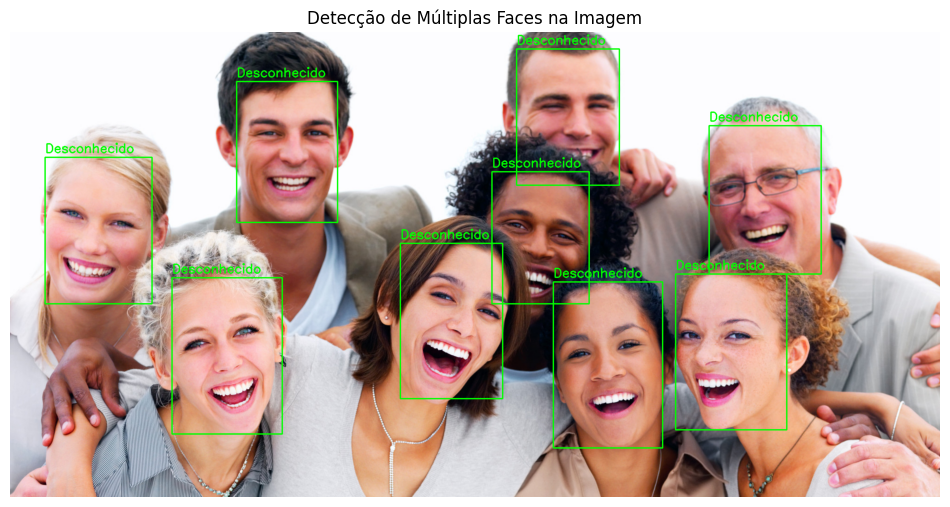

Resultado da detecção:
Face detectada: Desconhecido na posição (1036, 300, 209, 284)
Face detectada: Desconhecido na posição (487, 106, 217, 303)
Face detectada: Desconhecido na posição (839, 454, 220, 334)
Face detectada: Desconhecido na posição (75, 269, 230, 315)
Face detectada: Desconhecido na posição (1431, 520, 239, 335)
Face detectada: Desconhecido na posição (1503, 201, 241, 319)
Face detectada: Desconhecido na posição (1089, 36, 221, 293)
Face detectada: Desconhecido na posição (1168, 537, 235, 357)
Face detectada: Desconhecido na posição (348, 528, 237, 336)


In [3]:
from google.colab import files

# Faça o upload da imagem fornecida
uploaded = files.upload()

# Obtém o nome do arquivo
image_path = list(uploaded.keys())[0]

# Vamos simular um banco de dados para demonstração
# Na prática, você teria que gerar estes embeddings a partir de imagens conhecidas
known_face_encodings = []
known_face_names = []

# Processa a imagem
processed_image, recognized_faces_data = process_image(image_path, known_encodings=known_face_encodings, known_names=known_face_names)

# Exibe o resultado
plt.figure(figsize=(12, 12))
plt.imshow(cv2.cvtColor(processed_image, cv2.COLOR_BGR2RGB))
plt.title("Detecção de Múltiplas Faces na Imagem")
plt.axis('off')
plt.show()

# Imprime os resultados no console
print("Resultado da detecção:")
for face in recognized_faces_data:
    print(f"Face detectada: {face['name']} na posição {face['box']}")